---
title: "Make predictions as lasso model of SPI tree depth"

author: "Benjamin Doran"

date: today

---

## Setup

In [ ]:
using DrWatson
@quickactivate "Doran_etal_2022"

using SPI, MLJ
using MLJBase: train_test_pairs
using Clustering, Distances
using Muon, CSV, DataFrames
using StatsPlots, StatsBase
using NewickTree, NewickTreeTools
using Gotree_jll
using Random: seed!

using Distances
using NearestNeighbors

function getlims(x, y) 
    lims = extrema(vcat(x, y))
    lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
end

Base.@kwdef struct GroupedEuclidean{T} <: Metric
    groups::Vector{T}
end
function (dist::GroupedEuclidean)(r, a, b)
    for grp in dist.groups
        r += sqrt(sum(abs2.(a[grp] .- b[grp])))
    end
    r
end
function (dist::GroupedEuclidean)(a, b)
    r = zero(eltype(a))
    dist(r, a, b)
end
function (dist::GroupedEuclidean)(a::Number, b::Number)
    euclidean(a, b)
end
groupedeuclidean(a, b, intervals=collect(axes(a,1))) = GroupedEuclidean(intervals)(a, b)
groupedeuclidean!(r, a, b, intervals=collect(axes(a,1))) = GroupedEuclidean(intervals)(r, a, b)

get_predictions(ŷ, y) = ŷ
MLJ.reports_each_observation(::typeof(get_predictions)) = true;

In [ ]:
# @load LogisticClassifier pkg=MLJLinearModels verbosity=0
@load LassoRegressor pkg=MLJLinearModels verbosity=0
@load MultinomialClassifier pkg=MLJLinearModels verbosity=0
@load OneHotEncoder pkg=MLJModels verbosity=0
# DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree

In [1206]:
ddir = datadir("exp_pro", "BB728")
rdir = projectdir("_research", "metabolite_SBA_Lasso_model_mark2") |> mkpath
pdir = plotsdir("metabolite_SBA_Lasso_model_mark2") |> mkpath
biobank = readh5mu(joinpath(ddir, "BB728.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon ~/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 728 ✕ 21485
└ metabolites_foldchange
  AnnData object 728 ✕ 50
└ metabolites_millimolar
  AnnData object 728 ✕ 10
└ UPorder_oggs
  AnnData object 728 ✕ 10177
└ oggs
  AnnData object 728 ✕ 11248

In [ ]:
trn_mask = biobank.obs.inBB673 .== 1
tst_mask = biobank.obs.inBB673 .== 0
trn_mtx = biobank["UPorder_oggs"].X[:,:][trn_mask, :]
tst_mtx = biobank["UPorder_oggs"].X[:,:][tst_mask, :];
mtx = biobank["UPorder_oggs"].X[:,:];

In [ ]:
bbusv = SVD(
    biobank["UPorder_oggs"].obsm["inferredLSVs"][:,:],
    biobank["UPorder_oggs"].uns["UP_SVs"][:],
    biobank["UPorder_oggs"].varm["UP_RSVs"][:, :]',
    );
norm(mtx .- projectout(bbusv)) / norm(mtx)

In [ ]:
sigresdf = CSV.read(joinpath(ddir, "significant_metabolites_in_subsetSPItree_numisolatesperspecies=+20.csv"), DataFrame)

earlytreesigmetabolitesdf = filter(:node_depth_maxeffect => >(3.5), sigresdf) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df, :effect_size_abs => maximum) |>
    df -> sort(df, :effect_size_abs_maximum, rev=true)
middletreesigmetabolitesdf = filter(:node_depth_maxeffect => (x)-> 2 .< x .< 3.5, sigresdf) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df, :effect_size_abs => maximum) |>
    df -> sort(df, :effect_size_abs_maximum, rev=true)
latetreesigmetabolitesdf = filter(:node_depth_maxeffect => <(2), sigresdf) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df, :effect_size_abs => maximum) |>
    df -> sort(df, :effect_size_abs_maximum, rev=true);

metabolite_has_effectsize_mask = vcat(
    earlytreesigmetabolitesdf,
    middletreesigmetabolitesdf,
    latetreesigmetabolitesdf,
).effect_size_abs_maximum .> 0.6;

orderedmetabolites_names = vcat(
    earlytreesigmetabolitesdf.metabolite_name,
    middletreesigmetabolitesdf.metabolite_name,
    latetreesigmetabolitesdf.metabolite_name,
);
metabolite_mask_ord_early = indexin(earlytreesigmetabolitesdf.metabolite_name, replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>""));
metabolite_mask_ord_middle = indexin(middletreesigmetabolitesdf.metabolite_name, replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>""));
metabolite_mask_ord_late = indexin(latetreesigmetabolitesdf.metabolite_name, replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>""));
metabolite_mask_ord = indexin(orderedmetabolites_names, replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>""));

In [ ]:
bb_met_lfc = biobank["metabolites_foldchange"].X[:, :];
bb_met_lfc[isinf.(bb_met_lfc)] .= 0.0;
metabolicdistance = pairwise(Euclidean(), bb_met_lfc; dims=1);

In [ ]:
metabolicallyvariabledf = biobank.obs[trn_mask, :] |>
    df->DataFrames.transform(df, eachindex => :rowid) |>
    df->groupby(df, :species) |>
    df->combine(df, 
        nrow => :num_isolates, 
        :rowid => ((x)->maximum(metabolicdistance[x,x])) => :max_metabolicdistance,
        :rowid => ((x)->maximum(metabolicdistance[x,x]) > 20) => :isvariable,
        ) |>
    df->filter(:num_isolates => >=(10), df) |>
    df->sort(df, [:max_metabolicdistance, :num_isolates], rev=true)

specieswith20reps = metabolicallyvariabledf |>
    df -> filter(:num_isolates => >=(20), df) |>
    df -> filter(:species => !=("unclassified"), df) |>
    df -> sort(df, :num_isolates, rev=true)


spe20rep_mask = .!isnothing.(indexin(biobank.obs.species[trn_mask], specieswith20reps.species));

In [ ]:
full_train_mask = zeros(Bool, 728)
full_train_mask[trn_mask] .= spe20rep_mask;

full_test_mask = ones(Bool, 728)
full_test_mask[trn_mask] = .!spe20rep_mask
sum(full_train_mask), sum(full_test_mask)

In [ ]:
bbmtx = biobank["oggs"].X[:, :]
bbmtx_trn = bbmtx[full_train_mask, :]
bbmtx_tst = bbmtx[full_test_mask, :]
# filter out oggs that are constant
ogg_mask = vec(mapslices(c->std(c) > 0, bbmtx_trn, dims=1))
bbmtx_trn = bbmtx_trn[:, ogg_mask]
bbmtx_tst = bbmtx_tst[:, ogg_mask]
zbbmtx_trn = mapslices(StatsBase.zscore, bbmtx_trn, dims=1)
zbbmtx_tst = mapslices(StatsBase.zscore, bbmtx_tst, dims=1)
replace!(zbbmtx_tst, NaN=>0.) # replace zscored NaNs with zeros (it's what they were before)
bbusv_internal = svd(zbbmtx_trn)
BBUinternal_tst = projectinLSV(zbbmtx_tst, bbusv_internal)
BBpcs_trn = bbusv_internal.U * diagm(bbusv_internal.S)
BBpcs_tst = BBUinternal_tst * diagm(bbusv_internal.S);

In [1070]:
size(zbbmtx_trn)

(356, 5449)

In [ ]:
biobank.obs[!, "species_donor"] = biobank.obs.species .* "_" .* biobank.obs.donor
bbobs_trn = biobank.obs[full_train_mask, :]
bbobs_tst = biobank.obs[full_test_mask, :];

In [ ]:
subsetDij = biobank["UPorder_oggs"].obsp["SDij"][full_train_mask, full_train_mask];
subsettree_hc = hclust(subsetDij, linkage=:average, branchorder=:optimal)
subsettreestring = SPI.nwstr(subsettree_hc, bbobs_trn.ID; labelinternalnodes=false)
subsettree = readnw(subsettreestring);

In [ ]:
trnX = mtx[full_train_mask, :]
trnYdf = bbobs_trn;

metab_trnY = bb_met_lfc[full_train_mask, metabolite_mask_ord];
metab_tstY = bb_met_lfc[full_test_mask, metabolite_mask_ord];

measurable_metabolites_mask = mapslices(c->mean(c .==0.) < .9, metab_trnY, dims=1)|>vec;
keepmetabolites_mask = measurable_metabolites_mask .& metabolite_has_effectsize_mask

PCs_trnX = DataFrame(BBpcs_trn[:, 1:10], :auto);
PCs_tstX = DataFrame(BBpcs_tst[:, 1:10], :auto);

In [ ]:
specieslabels = [
    "Bacteroides uniformis",
    "Phocaeicola vulgatus",
    "Bacteroides thetaiotaomicron",
    "[Ruminococcus] gnavus",
    "Bifidobacterium breve",
    "[Eubacterium] rectale",
    "Dorea formicigenerans",
    "Coprococcus comes",
    "Blautia luti & Blautia wexlerae",
    "Anaerostipes hadrus",
]
shapes = permutedims([:circle, :rect, :star5, :diamond, :hexagon, :ltriangle, :pentagon, :utriangle, :dtriangle, :rtriangle, :star4])
speciescolors = wload(joinpath(ddir, "subsettreecolors.jld2"))["colors"]
speciescolors_ordered = permutedims(speciescolors[replace(indexin(sort(unique(trnYdf.species)), specieslabels), nothing=>9)])

In [ ]:
using Random: seed!
seed!(424242)
cv = StratifiedCV(nfolds=5, shuffle=true);
folds = train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.species);

## Make machine

In [ ]:
treedir = projectdir("_research", "metabolite_knn_model") |> mkpath

In [ ]:
streepaths =  [joinpath(treedir, "biobank-only_fold$(i)_supporttree.nw") for i in 1:5]

In [ ]:
foldtrees = readnw.(readline.(open.(streepaths)));

In [ ]:
support = 90
ps = []
for i in 1:5
    prunedtree = NewickTreeTools.as_polytomy(n->NewickTree.support(n)<(support/100), foldtrees[i])
    NewickTreeTools.as_polytomy!(n->NewickTree.distance(n)<1e-10, prunedtree)
    push!(ps, plot(prunedtree, fs=1, title="fold $i"))
end
plot(ps..., layout=grid(2,3))

## Make SPI-LASSO predictions

In [ ]:
function clusters_per_cutlevel(distfun::Function, tree::NewickTree.Node, ncuts::Number)
    minmax = extrema(mapinternalnodes(distfun, tree, tree))
    cuts = range(0, minmax[2], length=ncuts)
    clusts = [cuttree(distfun, tree, cut) for cut in cuts]
    clustmappings = map(c->getleafnames.(c), clusts)
    clustersmps = [vcat(clustmapping...) for clustmapping in clustmappings]
    clusterids = [Int.(vcat([zeros(length(c)) .+ j for (j, c) in enumerate(clustmapping)]...)) for clustmapping in clustmappings];
    return clusterids, clustersmps
end
# get_predictions(ŷ, y) = ŷ
# MLJ.reports_each_observation(::typeof(get_predictions)) = true;

In [ ]:
K = 1 # Make predictions with SPI-LASSO
λ = 0.001
NCUTS = 10
support = 90


mdl = MLJLinearModels.LassoRegressor(lambda=λ)


prunedtrees = map(foldtrees) do tree
    prunedtree = NewickTreeTools.as_polytomy(n->NewickTree.support(n)<(support/100), tree)
end;

cuttrees = clusters_per_cutlevel.(NewickTreeTools.network_distance, prunedtrees, NCUTS)
clustIDs = map(stack, first.(cuttrees))
clustSmps = map(stack, last.(cuttrees));

# individual_metabolite_results = []
# all_fold_tst_preds_dfs = []
# all_fold_trn_preds_dfs = []
oof_preds_df_stacked = DataFrame()
inf_preds_df_stacked = DataFrame()
coefdf = DataFrame()
for (i, (fold_trn, fold_tst)) in enumerate(folds)
# (i, (fold_trn, fold_tst)) = (1, folds[1])

    # use tree to get lineage traces for each training and test sample
    fold_usv = svd(zbbmtx_trn[fold_trn, :]);
    partitions = getintervals(fold_usv.S);
    PCs = fold_usv.U * diagm(fold_usv.S)
    search_btree = BallTree(PCs', GroupedEuclidean(getintervals(fold_usv.S)));
    proj_trn = projectinLSV(zbbmtx_trn[fold_trn, :], fold_usv) * diagm(fold_usv.S)
    proj_tst = projectinLSV(zbbmtx_trn[fold_tst, :], fold_usv) * diagm(fold_usv.S)
    trn_nns, trn_dists = knn(search_btree, proj_trn', K, true)
    tst_nns, tst_dists = knn(search_btree, proj_tst', K, true)
    orderoftreepaths = indexin(clustSmps[i][:, 1], bbobs_trn.ID[fold_trn])
    
    # one-hot-encode the lineage trace
    trnX = clustIDs[i][orderoftreepaths, :]    
    trnXdf = coerce(
        DataFrame(string.(trnX), ["treedepth_$i" for i in 1:NCUTS]), 
        Dict(Symbol("treedepth_$i") => Multiclass for i in 1:NCUTS)
    )
    tstXdf = trnXdf[vec(stack(tst_nns)), :]
    hot = machine(OneHotEncoder(), trnXdf)
    hotmach = fit!(hot, verbosity=0)
    trnWdf = MLJ.transform(hotmach, trnXdf)
    tstWdf = MLJ.transform(hotmach, tstXdf)

    # fit lasso model
    individual_metabolite_results = []
    for (target_idx, target) in enumerate(orderedmetabolites_names)
        mach = machine(mdl, trnWdf, metab_trnY[fold_trn, target_idx])
        fit!(mach, verbosity=0)

        # save results of trained model
        oof_preds_df_stacked = vcat(oof_preds_df_stacked, DataFrame(
            :row_id => fold_tst,
            :metabolite_name => target,
            :fold => i,
            :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, tstWdf),
        ))

        inf_preds_df_stacked = vcat(inf_preds_df_stacked, DataFrame(
            :row_id => fold_trn,
            :metabolite_name => target,
            :fold => i,
            :truth => metab_trnY[fold_trn, target_idx],
            :preds => MLJ.predict(mach, trnWdf),
        ))

        coefdf = vcat(coefdf, stack(DataFrame(fitted_params(mach).coefs)) |>
            df-> DataFrames.select(df,
                :value => ByRow(x->target) => :metabolite_name,
                :value => ByRow(x->i) => :fold,
                :variable => (x->split.(x, "__")) => [:treedepth, :class],
                :value => :ceof,
            )
        )
    end;
end

oof_preds_df = leftjoin(
    unstack(oof_preds_df_stacked, [:row_id, :fold], :metabolite_name, :truth; renamecols=(s)-> s*"_true"),
    unstack(oof_preds_df_stacked, [:row_id], :metabolite_name, :preds; renamecols=(s)-> s*"_pred_sbalasso"),
    on=:row_id,
)
CSV.write(joinpath(rdir, "oof_predictions_SPItreeLASSO_lambda=$(λ)_support=$(support)_ncuts=$(NCUTS).csv"), oof_preds_df)
inf_preds_df = leftjoin(
    unstack(inf_preds_df_stacked, [:row_id, :fold], :metabolite_name, :truth; renamecols=(s)-> s*"_true"),
    unstack(inf_preds_df_stacked, [:row_id, :fold], :metabolite_name, :preds; renamecols=(s)-> s*"_pred_sbalasso"),
    on=[:row_id, :fold],
)
CSV.write(joinpath(rdir, "infold_predictions_SPItreeLASSO_lambda=$(λ)_support=$(support)_ncuts=$(NCUTS).csv"), inf_preds_df)
CSV.write(joinpath(rdir, "coefs_SPItreeLASSO_lambda=$(λ)_support=$(support)_ncuts=$(NCUTS).csv"), coefdf)

## Show SPI-LASSO prediction results

In [ ]:
oof_preds_df = CSV.read(joinpath(rdir, "oof_predictions_SPItreeLASSO_lambda=$(λ)_support=$(support)_ncuts=$(NCUTS).csv"), DataFrame)
inf_preds_df = CSV.read(joinpath(rdir, "infold_predictions_SPItreeLASSO_lambda=$(λ)_support=$(support)_ncuts=$(NCUTS).csv"), DataFrame)
coefdf = CSV.read(joinpath(rdir, "coefs_SPItreeLASSO_lambda=$(λ)_support=$(support)_ncuts=$(NCUTS).csv"), DataFrame);

In [ ]:
knn_oof_preds_df = CSV.read(projectdir("_research", "metabolite_knn_model", "oof_preds__K=1_nboot=100_support=90.csv"), DataFrame);
lasso_oof_preds_df = CSV.read(projectdir("_research", "metabolite_lasso_model", "oof_lasso_preds_lambda=0.01.csv"), DataFrame);

In [ ]:
# oof_preds_df = CSV.read(joinpath(rdir, "oof_predictions_SPItreeLASSO_lambda=0.01_support=0_ncuts=10.csv"), DataFrame)
# coefdf = CSV.read(joinpath(rdir, "coefs_SPItreeLASSO_lambda=0.01_support=0_ncuts=10.csv"), DataFrame);

In [ ]:
# metabolite_name = "Propionate"
# metabolite_name = "Acetate"
# metabolite_name = "Aspartate"
# metabolite_name = "Succinate"
# metabolite_name = "Glycine"
metabolite_name = "Serine"

# metabolite_name = "Butyrate"
# metabolite_name = "Tryptamine"
# metabolite_name = "Phenylacetate"


# metabolite_name = "Lysine"
# metabolite_name = "Desaminotyrosine"
# metabolite_name = "Phenol"

In [ ]:
preds_knn = knn_oof_preds_df[:, metabolite_name * "_pred_mean"];

In [ ]:
predslasso = oof_preds_df[:,  metabolite_name * "_pred_sbalasso"]
truth = oof_preds_df[:, metabolite_name * "_true"]
species = trnYdf.species[Int.(oof_preds_df.row_id)];

lims = extrema(vcat(predslasso, truth))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(predslasso, truth,
    group=species,
    lims=lims,
    title="SPI LASSO prediction K=$(K) support>$support",
    ylabel=metabolite_name * " (truth)",
    xlabel=metabolite_name * " (prediction)",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
    margin=5Plots.Measures.mm,
)

In [ ]:
savefig(joinpath(pdir, "$(metabolite_name)_scatter_predictions_SBAlasso_model_K=$(K)_support=$(support).pdf"))

In [ ]:
lims = extrema(vcat(predslasso, truth))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(preds_knn, truth,
    group=species,
    lims=lims,
    title="SPI KNN prediction K=1 support>90",
    ylabel=metabolite_name * " (truth)",
    xlabel=metabolite_name * " (prediction)",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
    margin=5Plots.Measures.mm,

)

In [ ]:
# savefig(joinpath(pdir, "$(metabolite_name)_scatter_predictions_knn_model_K=$(K)_support=$(support).pdf"))

In [ ]:
lims = extrema(vcat(predslasso, truth))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(predslasso, preds_knn,
    group=species,
    lims=lims,
    title="SBA LASSO vs. SBA KNN predictions",
    ylabel=metabolite_name * " SBA knn (prediction)",
    xlabel=metabolite_name * " SBA lasso (prediction)",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
    margin=5Plots.Measures.mm,
)

In [ ]:
# savefig(joinpath(pdir, "$(metabolite_name)_scatter_prediction_comparison_knn_to_SBAlasso_K=$(K)_support=$(support).pdf"))

### Coefs plot

In [ ]:
coef_mtxdf = coefdf |>
    df -> DataFrames.groupby(df, [:metabolite_name, :treedepth]) |>
    df -> DataFrames.combine(df, :ceof => (x->abs.(mean(x))) => :coef) |>
    df -> unstack(df, :metabolite_name, :treedepth, :coef) |>
    df -> df[keepmetabolites_mask, :] |>
    df -> sort(df, names(df)[2:end]);

In [ ]:
coefmtx = Matrix(coef_mtxdf[:, 2:end])
heatmap(coefmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), coef_mtxdf.metabolite_name),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="abs(mean(coef))",
    xlabel="tree cut",
    c=[:white, :green],
    # c=:viridis,
    size=(900, 600),
)

In [ ]:
coef_mtxdf = coefdf |>
    df -> DataFrames.groupby(df, [:metabolite_name, :treedepth]) |>
    df -> DataFrames.combine(df, :ceof => (x->maximum(abs.(x))) => :coef) |>
    df -> unstack(df, :metabolite_name, :treedepth, :coef) |>
    df -> df[keepmetabolites_mask, :] |>
    df -> sort(df, names(df)[2:end]);

In [ ]:
coefmtx = Matrix(coef_mtxdf[:, 2:end])
heatmap(coefmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), coef_mtxdf.metabolite_name),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="max(abs(coef))",
    xlabel="tree cut",
    c=[:white, :green],
    size=(900, 600),
)

In [ ]:
coef_mtxdf = coefdf |>
    df -> DataFrames.groupby(df, [:metabolite_name]) |>
    df -> DataFrames.combine(df, :ceof => (x->sum(x.>0.05) / length(x)) => :coef) |>
    # df -> unstack(df, :metabolite_name, :treedepth, :coef) |>
    df -> sort(df, :coef)

### Performance plots

In [ ]:
mnames = string.(orderedmetabolites_names[keepmetabolites_mask]);

In [ ]:
function get_scores(fun, df, predname; groupcol=:fold, mnames=mnames) 
    combine(groupby(df, groupcol)) do gdf 
        ŷs = gdf[:, Cols(mnames .* "_pred_".* predname)]
        ys = gdf[:, Cols(mnames .* "_true")]
        scores = map(zip(eachcol(ŷs), eachcol(ys))) do (ŷ, y)
            fun(ŷ, y)
        end |> permutedims
        scores
    end |>
    Matrix |>
    x->getindex(x, :, axes(x,2)[2:end]) |>
    permutedims
end

In [ ]:
func = rsquared

sbalasso_scores = map(["sbalasso"]) do type
    scores = get_scores(func, oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
knn_scores = map(["mean"]) do type
    scores = get_scores(func, knn_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
all_scores = map(["full", "top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2), std(scores, dims=2)
end

scores_means = hcat(first.(sbalasso_scores)..., first.(knn_scores)..., first.(all_scores)...)
scores_stds = hcat(last.(sbalasso_scores)..., last.(knn_scores)..., last.(all_scores)...);

In [ ]:
groupedbar(scores_means,
    errorbar=scores_stds,
    xticks=(1:length(mnames), mnames),
    xtickfontsize=9,
    xrotation=90,
    ylabel="R²",
    # label=["SPI-NN" "full lasso" "top10 lasso" "top3 lasso"],
    label=["SBA-lasso" "SBA-knn" "full lasso" "top3 lasso"],
    xgrid=false,
    size=(900, 400),
    leftmargin=.5Plots.Measures.cm,
    bottommargin=2Plots.Measures.cm,
    legend=:outertop,
)
vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "rsquared_groupedbar_SBAlasso-SBAknn-fulllasso-top3lasso.pdf"))

In [ ]:
func = mae

sbalasso_scores = map(["sbalasso"]) do type
    scores = get_scores(func, oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
knn_scores = map(["mean"]) do type
    scores = get_scores(func, knn_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
all_scores = map(["full", "top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2), std(scores, dims=2)
end

scores_means = hcat(first.(sbalasso_scores)..., first.(knn_scores)..., first.(all_scores)...)
scores_stds = hcat(last.(sbalasso_scores)..., last.(knn_scores)..., last.(all_scores)...);

In [ ]:
groupedbar(scores_means,
    errorbar=scores_stds,
    xticks=(1:length(mnames), mnames),
    xtickfontsize=9,
    xrotation=90,
    ylabel="MAE (log2FC from standard)",
    # label=["SPI-NN" "full lasso" "top10 lasso" "top3 lasso"],
    label=["SBA-lasso" "SBA-knn" "full lasso" "top3 lasso"],
    xgrid=false,
    size=(900, 400),
    leftmargin=.5Plots.Measures.cm,
    bottommargin=2Plots.Measures.cm,
    legend=:outertop,
)
vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "mae_groupedbar_SBAlasso-SBAknn-fulllasso-top3lasso.pdf"))

In [ ]:
mnames = [
    "Succinate", 
    "Tryptamine",
    "Phenylacetate",
    "Glycine",
    "Butyrate",
    "Acetate",
    "Serine",
    "Valerate",
    "5-Aminovalerate",
    "2-Methylbutyrate",
    "Isovaleric-Acid"
]

In [ ]:
function get_scores(fun, df, predname; groupcol=:fold, mnames=mnames) 
    combine(groupby(df, groupcol)) do gdf 
        ŷs = gdf[:, Cols(mnames .* "_pred_".* predname)]
        ys = gdf[:, Cols(mnames .* "_true")]
        scores = map(zip(eachcol(ŷs), eachcol(ys))) do (ŷ, y)
            fun(ŷ, y)
        end |> permutedims
        scores
    end |>
    Matrix |>
    x->getindex(x, :, axes(x,2)[2:end]) |>
    permutedims
end

In [ ]:
func = rsquared

sbalasso_scores = map(["sbalasso"]) do type
    scores = get_scores(func, oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
knn_scores = map(["mean"]) do type
    scores = get_scores(func, knn_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
all_scores = map(["top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2), std(scores, dims=2)
end

scores_means = hcat(first.(sbalasso_scores)..., first.(knn_scores)..., first.(all_scores)...)
scores_stds = hcat(last.(sbalasso_scores)..., last.(knn_scores)..., last.(all_scores)...);

In [ ]:
groupedbar(scores_means,
    errorbar=scores_stds,
    xticks=(1:length(mnames), mnames),
    xtickfontsize=9,
    xrotation=90,
    ylabel="R²",
    # label=["SPI-NN" "full lasso" "top10 lasso" "top3 lasso"],
    label=["SBA-lasso" "SBA-knn" "full lasso" "top3 lasso"],
    xgrid=false,
    size=(900, 400),
    leftmargin=.5Plots.Measures.cm,
    bottommargin=2Plots.Measures.cm,
    legend=:outertop,
    c=[5 1 4],
)
# vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "rsquared_groupedbar_SBAlasso-SBAknn-fulllasso-top3lasso.pdf"))

In [ ]:
func = mae

sbalasso_scores = map(["sbalasso"]) do type
    scores = get_scores(func, oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
knn_scores = map(["mean"]) do type
    scores = get_scores(func, knn_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
all_scores = map(["top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2), std(scores, dims=2)
end

scores_means = hcat(first.(sbalasso_scores)..., first.(knn_scores)..., first.(all_scores)...)
scores_stds = hcat(last.(sbalasso_scores)..., last.(knn_scores)..., last.(all_scores)...);

In [ ]:
groupedbar(scores_means,
    errorbar=scores_stds,
    xticks=(1:length(mnames), mnames),
    xtickfontsize=9,
    xrotation=90,
    ylabel="MAE (log2FC from standard)",
    # label=["SPI-NN" "full lasso" "top10 lasso" "top3 lasso"],
    label=["SBA-lasso" "SBA-knn" "full lasso" "top3 lasso"],
    xgrid=false,
    size=(900, 400),
    leftmargin=.5Plots.Measures.cm,
    bottommargin=2Plots.Measures.cm,
    legend=:outertop,
    c=[5 1 4],
)
# vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "mae_groupedbar_SBAlasso-SBAknn-fulllasso-top3lasso.pdf"))

In [ ]:
oof_preds_df_stacked

In [ ]:
lasso_oof_preds_df = CSV.read(projectdir("_research/metabolite_lasso_model/oof_lasso_preds_lambda=0.01.csv"), DataFrame);

In [ ]:
mergeddf = leftjoin(oof_preds_df, lasso_oof_preds_df, on=:row_id, makeunique=true);

In [ ]:
preds_knn = mergeddf[:, metabolite_name * "_pred_mean"]
preds_full = mergeddf[:, metabolite_name * "_pred_full"]
preds_top10 = mergeddf[:, metabolite_name * "_pred_top10"]
preds_top3 = mergeddf[:, metabolite_name * "_pred_top3"]
preds_std = mergeddf[:, metabolite_name * "_pred_std"]
truth = mergeddf[:, metabolite_name * "_true"]
species = trnYdf.species[Int.(mergeddf.row_id)];

In [ ]:
lims = extrema(vcat(preds_knn, preds_full))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(preds_knn, preds_full,
    group=species,
    lims=lims,
    title="$metabolite_name comparison",
    ylabel="Full spectrum prediction",
    xlabel="KNN prediction K=$K support>$(support)",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
)

In [ ]:
savefig(joinpath(pdir, "$(metabolite_name)_comparison_knn_to_full_K=$(K)_support=$(support).pdf"))

In [ ]:
preds_full = mergeddf[:, metabolite_name * "_pred_full"]
# preds_std = mergeddf[:, metabolite_name * "_pred_std"]
truth = mergeddf[:, metabolite_name * "_true"]
species = trnYdf.species[Int.(mergeddf.row_id)];

lims = extrema(vcat(preds_full, truth))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(preds_full, truth,
    group=species,
    lims=lims,
    title="lasso full spectrum prediction",
    ylabel=metabolite_name,
    xlabel="prediction",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
    # legendfontsize=6,
)

## R squared

In [ ]:
rsquaredoflassovsspinn = map(orderedmetabolites_names[keepmetabolites_mask]) do mname
    rsquared(
        mergeddf[:, mname * "_pred_full"], 
        mergeddf[:, mname * "_pred_mean"], 
    )
end

In [ ]:
bar(rsquaredoflassovsspinn,
    # errorbar=corrbias_stds,
    ylims=(-0.6, 1.1),
    yticks=-.5:.25:1,
    xticks=(1:length(rsquaredoflassovsspinn), orderedmetabolites_names[keepmetabolites_mask]),
    xtickfontsize=9,
    xrotation=-90,
    title="R² of full spectrum lasso vs. SPI nearest neighbors (k = $K, support ≥ $support)",
    label="R²",
    xgrid=false,
    size=(1500, 400),
    bottommargin=25Plots.Measures.mm,
    legend=:none,
)
vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "Rsquared_of_fulllasso_vs_SPI-NN_K=$(K)_support=$(support).pdf"))

## Sweep Lambda for full training set

In [ ]:
subsettree

In [ ]:
isinternal = map(!isleaf, prewalk(subsettree));

In [ ]:
trnXdf_all = map(prewalk(subsettree)) do node
    tmp = zeros(nrow(bbobs_trn))
    tmp[indexin(getleafnames(node), bbobs_trn.ID)] .= 1
    "node_id__$(id(node))" => tmp
end |> DataFrame;
trnXdf = trnXdf_all[:, isinternal];

In [ ]:
K = 1 # Make predictions with SPI-LASSO
λ = 0.001
NCUTS = 10
support = 95


mdl = MLJLinearModels.LassoRegressor(lambda=λ)

pspitree = NewickTreeTools.as_polytomy(n->NewickTree.support(n)<(support/100), subsettree)

# cuttreeclusts = clusters_per_cutlevel(NewickTreeTools.network_distance, pspitree, NCUTS)
# # clustIDs = map(stack, first.(cuttrees))
# # clustSmps = map(stack, last.(cuttrees));
# clustsIDS356 = hcat(first(cuttreeclusts)...)
# clustsSMPS356 = hcat(last(cuttreeclusts)...);

In [ ]:
# use tree to get lineage traces for each training and test sample
usv = svd(zbbmtx_trn);
partitions = getintervals(usv.S);
PCs = usv.U * diagm(usv.S)
search_btree = BallTree(PCs', GroupedEuclidean(getintervals(usv.S)));
proj_trn = projectinLSV(zbbmtx_trn, usv) * diagm(usv.S)
proj_tst = projectinLSV(zbbmtx_tst, usv) * diagm(usv.S)
trn_nns, trn_dists = knn(search_btree, proj_trn', K, true)
tst_nns, tst_dists = knn(search_btree, proj_tst', K, true)
# orderoftreepaths = indexin(clustsSMPS356[:, 1], bbobs_trn.ID);

In [ ]:
# # one-hot-encode the lineage trace
# trnX = clustsIDS356[orderoftreepaths, :]    
# trnXdf = coerce(
#     DataFrame(string.(trnX), ["treedepth_$i" for i in 1:NCUTS]), 
#     Dict(Symbol("treedepth_$i") => Multiclass for i in 1:NCUTS)
# )
# tstXdf = trnXdf[vec(stack(tst_nns)), :]
# hot = machine(OneHotEncoder(), trnXdf)
# hotmach = fit!(hot, verbosity=0)
# trnWdf = MLJ.transform(hotmach, trnXdf)
# tstWdf = MLJ.transform(hotmach, tstXdf);

In [ ]:
trnWdf = trnXdf;
tstXdf = trnXdf[vec(stack(tst_nns)), :];
tstWdf = tstXdf;

In [ ]:
target_idx = findfirst(==("Acetate"), orderedmetabolites_names)

In [ ]:
REPS = 5
FOLDS_PER_REP = 5
NFOLDS = REPS * FOLDS_PER_REP
COEF_NAMES = names(trnWdf);
MEASURE_NAMES = ["rsquared", "RMSE", "MAE"];
MEASURES = [rsquared, rmse, mae]
simplecv = CV(nfolds=FOLDS_PER_REP, shuffle=true, rng=42);

In [ ]:
fullsweepdf = DataFrame()
allmodelreports = []
for (target_idx, target) in enumerate(orderedmetabolites_names)
# (target_idx, target) = (15, "Acetate")
    for λ in exp10.(-8:0.25:0)
    # lambda = exp10.(0:0)[1]
        lassomdl = MLJLinearModels.LassoRegressor(lambda=λ);
        mach = machine(lassomdl, trnWdf, metab_trnY[:, target_idx])
        mach_report = Base.with_logger(Base.NullLogger()) do # ignore warnings about slow convergence
             evaluate!(mach,
                resampling=simplecv, repeats=REPS,
                measures=MEASURES,
                verbosity=0,
            )
        end
        measures_perfold_df = DataFrame(stack(mach_report.per_fold), MEASURE_NAMES)
        coefvals_perfold_df = map(first.(mach_report.fitted_params_per_fold)) do coef
            last.(coef)
        end |> stack |> permutedims |> x->DataFrame(x, COEF_NAMES)
        iteration_df = DataFrame(
            :fold_id => 1:NFOLDS,
            :metabolite_name => target,
            :metabolite_idx => target_idx,
            :lambda_val => λ,
        )
        perfolddf = hcat(iteration_df, measures_perfold_df, coefvals_perfold_df)
        fullsweepdf = vcat(fullsweepdf, perfolddf);
        push!(allmodelreports, deepcopy(mach_report))
    end
end
CSV.write(joinpath(rdir, "Lasso_356_SPItree_lambdasweep.csv"), fullsweepdf)

In [ ]:
save(joinpath(rdir, "Lasso_356_SPItree_lambdasweep.jld2"), Dict("allmodels"=>allmodelreports))

In [ ]:
fullsweepdf = CSV.read(joinpath(rdir, "Lasso_356_SPItree_lambdasweep.csv"), DataFrame);

## Plot lambda sweep performance per metabolite

In [ ]:
ttest(col) = begin
    µ = mean(col)
    σ = std(col)
    # 95 conf.int for t.test with D.F. 24 (1.711σ)
    lo = µ - 2σ
    hi = µ + 2σ
    mean(hi .< 0 .|| 0 .< lo)
end

In [ ]:
# mname = "Acetate"
# mname = "Phenylacetate"
mname = "Butyrate"
# mname = "2-Methylbutyrate"

In [ ]:
metab_sweep_df = filter(:metabolite_name => ==(mname), fullsweepdf);

In [ ]:
measuresbylambdadf = metab_sweep_df |>
    df -> groupby(df, :lambda_val) |>
    df -> combine(df, 
        :rsquared => mean,
        :RMSE => mean,
        :MAE => mean,
        :rsquared => std,
        :RMSE => std,
        :MAE => std,
        r"node_id_.*" =>
        ((df...) -> begin
            mtx = stack(df)
            µ = mean(mtx, dims=1)
            σ = std(mtx, dims=1)
            # 95 conf.int for t.test with D.F. 24
            lo = µ .- 2σ
            hi = µ .+ 2σ
            sum(hi .< 0 .|| 0 .< lo)
        end) => :pct_sig_coeffs
    );

In [ ]:
p1 = @df measuresbylambdadf plot(:lambda_val,
    :rsquared_mean, ribbon=:rsquared_std,
    xscale=:log10,
    alpha=.5,
    grid=false,
    label="",
    xlabel="λ",
    ylabel="$mname R²",
    xticks=exp10.(-8:0),
    xrotation=45,
)
p1 = hline!([1], label="", linestyle=:dash, c=:grey,)
p2 = @df measuresbylambdadf plot(:lambda_val,
    :RMSE_mean, ribbon=:RMSE_std,
    xscale=:log10,
    alpha=.5,
    grid=false,
    label="",
    xlabel="λ",
    ylabel="RMSE",
    xticks=exp10.(-8:0),
    xrotation=45,
)
p3 = @df measuresbylambdadf plot(:lambda_val,
    :MAE_mean, ribbon=:MAE_std,
    xscale=:log10,
    alpha=.5,
    grid=false,
    label="",
    xlabel="λ",
    ylabel="MAE",
    xticks=exp10.(-8:0),
    xrotation=45,
)
p4 = @df measuresbylambdadf plot(:lambda_val,
    :pct_sig_coeffs, # * 100,
    xscale=:log10,
    # ylims=(0,100),
    grid=false,
    label="",
    xlabel="λ",
    ylabel="# (0.0 > µ ± 2σ)",
    xticks=exp10.(-8:0),
    xrotation=45,
)
plot(p1, p2, p3, p4, 
    layout=grid(1,4), 
    size=(1500, 400),
    margin=10Plots.Measures.mm,
)

In [ ]:
internallambdavals = metab_sweep_df |>
    df -> groupby(df, :lambda_val) |>
    df -> combine(df, [c => ttest for c in 8:362]) |>
    df -> combine(df, [Cols(:lambda_val, c) => (lambda, x)->isnothing(findlast(x.>0)) ? 1e-9 : lambda[findlast(x.>0)] for c in 2:356]) |>
    Matrix

In [ ]:
metabbranchweights = zeros(length(isinternal))
metabbranchweights[isinternal] .= log10.(vec(internallambdavals));

In [ ]:
tplot = plot(subsettree,
    title="Subset SPI tree",
    fs=1,
    line_z = permutedims(metabbranchweights[2:end]),
    lw=1.5,
    sq=true,
    label="",
    c=:amp,
)
mplot = heatmap(metab_trnY[indexin(getleafnames(subsettree), bbobs_trn.ID), [findfirst(==(mname), orderedmetabolites_names)]], 
    c=:bwr,
    clims = (-11,11), #extrema(metab_trnY[:, [15]]) |> x->abs.(x) |> maximum |> x->(-x, x),
    cbar=:none,
    ticks=false,
    title=mname,
    framestyle=:none,
    # ylabel="isolate",
    label="",
    grid=false,
    leftmargin=-5Plots.Measures.mm,
)

# eplot = plot([NaN], framestyle=:none, label=false,)
# cplot1 = plot([NaN], line_z=[NaN], c=:amp, clims=(-9, 0), colorbar=:top, label="", framestyle=:none)
# cplot2 = plot([NaN], line_z=[NaN], c=:bwr, clims=(-11, 11), colorbar=:top, label="", framestyle=:none)

layout = @layout [a b{.2w}]
plot(tplot, mplot; layout, size=(700, 1000), link=:y)

In [ ]:
coef_means = metab_sweep_df |> 
    df -> groupby(df, :lambda_val) |>
    df -> combine(df,
        [c => mean for c in 8:362]
    ) |>
    df -> Matrix(df[:, 2:end]);

In [ ]:
coef_stds = metab_sweep_df |> 
    df -> groupby(df, :lambda_val) |>
    df -> combine(df,
        [c => std for c in 8:362]
    ) |>
    df -> Matrix(df[:, 2:end]);

In [ ]:
treedepth_internalnodes = mapinternalnodes(subsettree) do node
    patristic_distance(subsettree, node)
end |> vec;

In [ ]:
internallambdavals = metab_sweep_df |>
    df -> groupby(df, :lambda_val) |>
    df -> combine(df, [c => ttest for c in 8:362]) |>
    df -> combine(df, [Cols(:lambda_val, c) => (lambda, x)->isnothing(findlast(x.>0)) ? 1e-9 : lambda[findlast(x.>0)] for c in 2:356]) |>
    Matrix |> 
    vec;

In [ ]:
sum(internallambdavals .> 1e-3)

In [ ]:
plot(exp10.(-8:0.25:0), coef_means[:, internallambdavals .> 1e-3], 
    # ribbon=coef_stds[:, internallambdavals .> 1e-3], 
    alpha=.5, #c=:black,
    c=:hawaii, 
    line_z = permutedims(treedepth_internalnodes[internallambdavals .> 1e-3]),
    lw=2,
    label="", xscale=:log10,
    grid=false,
    title="Coeff. ≠ 0 when 0.001 > λ > 1",
    ylabel="$mname coefficient",
    xlabel="lambda",
    colorbartitle="distance from root",
    xticks=exp10.(-8:0),
)

## Test predictions

In [ ]:
load(joinpath(rdir, "Lasso_356_SPItree_lambdasweep.jld2"))["allmodels"]

In [ ]:
allmodels

In [ ]:
test_set_measures = DataFrame()
allmodels = []
for (target_idx, target) in enumerate(orderedmetabolites_names)
# (target_idx, target) = (15, "Acetate")
    for λ in exp10.(-8:0.25:0)
    # λ = exp10.(0:0)[1]
        lassomdl = MLJLinearModels.LassoRegressor(lambda=λ);
        mach = machine(lassomdl, trnWdf, metab_trnY[:, target_idx])
        mach = Base.with_logger(Base.NullLogger()) do # ignore warnings about slow convergence
             fit!(mach)
        end
        perfolddf = DataFrame(
            :metabolite_name => target,
            :metabolite_idx => target_idx,
            :lambda_val => λ,
            :rsquared => rsquared(MLJ.predict(mach, tstWdf), metab_tstY[:, target_idx]),
            :RMSE => rmse(MLJ.predict(mach, tstWdf), metab_tstY[:, target_idx]),
            :MAE => mae(MLJ.predict(mach, tstWdf), metab_tstY[:, target_idx]),
        )
        test_set_measures = vcat(test_set_measures, perfolddf);
        push!(allmodels, deepcopy(mach))
    end
end
CSV.write(joinpath(rdir, "Lasso_356_testsetpredictionsmeasures.csv"), fullsweepdf)
save(joinpath(rdir, "Lasso_356_modelsfromall356trainingsetisolates.jld2"), Dict("allmodels"=>allmodels))

In [ ]:
nrow(tstXdf)

In [ ]:
tstr2 = unstack(test_set_measures, :lambda_val, :metabolite_name, :rsquared)
@df tstr2 plot(:lambda_val, Matrix(tstr2[:, 2:end]),
    xscale=:log10,
    label = permutedims(names(tstr2)[2:end]),
    legend=:outerright,
    size=(600,600),
    title="Test set performance (n=372)",
    ylabel="R²",
    xlabel="λ",
)
hline!([1], label="", c=:grey, linestyle=:dash)

In [ ]:
lasso = MLJLinearModels.LassoRegressor()
r = range(lasso, :lambda, lower=1e-8, upper=1e+0, scale=:log10)

In [ ]:
cv

In [ ]:
test_set_measures_best = DataFrame()
allmodels_best = []
for (target_idx, target) in enumerate(orderedmetabolites_names)
# (target_idx, target) = (15, "Acetate")
    # for λ in exp10.(-8:0.25:0)
    # λ = exp10.(0:0)[1]
        lassomdl = MLJ.TunedModel(lasso,
            resampling=cv,
            repeats=REPS,
            tuning=Grid(resolution=33),
            range=r,
            measure=rsquared
        );
        mach = machine(lassomdl, trnWdf, metab_trnY[:, target_idx])
        mach = Base.with_logger(Base.NullLogger()) do # ignore warnings about slow convergence
             fit!(mach)
        end
        perfolddf = DataFrame(
            :metabolite_name => target,
            :metabolite_idx => target_idx,
            :lambda_val => λ,
            :rsquared => rsquared(MLJ.predict(mach, tstWdf), metab_tstY[:, target_idx]),
            :RMSE => rmse(MLJ.predict(mach, tstWdf), metab_tstY[:, target_idx]),
            :MAE => mae(MLJ.predict(mach, tstWdf), metab_tstY[:, target_idx]),
        )
        test_set_measures_best = vcat(test_set_measures_best, perfolddf);
        push!(allmodels_best, deepcopy(mach))
    # end
end
CSV.write(joinpath(rdir, "Lasso_356_testsetpredictionsmeasures_tuned.csv"), test_set_measures_best)
save(joinpath(rdir, "Lasso_356_modelsfromall356trainingsetisolates_tuned.jld2"), Dict("allmodels"=>allmodels_best))

In [ ]:
sort(test_set_measures_best, :rsquared, rev=true)

In [ ]:
plt_tstdf = sort(test_set_measures_best, :rsquared, rev=true)
@df  plt_tstdf bar(
    :metabolite_name, :rsquared, 
    ylims=(-1.5, 1),
    xticks=((1:35) .-.5, :metabolite_name),
    xrotation=90,
    grid=false,
    bottommargin=10Plots.Measures.mm,
    ylabel="R²",
    label="",
    title="Test set of different species (N=372)",
)
vline!([7], label="", c=:grey, linestyle=:dash)
annotate!([3, 25], [.9, .9], [text("+R²",9), text("-R²",9)])

In [ ]:
tstWdf

## Ancestral encoding cross-fold validation

In [483]:
treedir = projectdir("_research", "metabolite_knn_model") |> mkpath

"/Users/ben/projects/Doran_etal_2022/_research/metabolite_knn_model"

In [ ]:
streepaths =  [joinpath(treedir, "biobank-only_fold$(i)_supporttree.nw") for i in 1:5]

In [ ]:
foldtrees = readnw.(readline.(open.(streepaths)));

In [ ]:
support = 90
ps = []
for i in 1:5
    prunedtree = NewickTreeTools.as_polytomy(n->NewickTree.support(n)<(support/100), foldtrees[i])
    NewickTreeTools.as_polytomy!(n->NewickTree.distance(n)<1e-10, prunedtree)
    push!(ps, plot(prunedtree, fs=1, title="fold $i"))
end
plot(ps..., layout=grid(2,3))

### Make SPI-LASSO predictions

In [1207]:
1e-2 == exp10(-2)

true

In [619]:
function ladderize!(t; rev=false)
    function walk!(n)
        if isleaf(n)
            return 1
        else 
            numleaves = [walk!(c) for c in children(n)]
            n.children .= n.children[sortperm(numleaves, rev=rev)]
            return sum(numleaves)
        end        
    end
    walk!(t)
end

ladderize! (generic function with 1 method)

In [837]:
map(folds) do (fold_trn, fold_tst)
    sort(countmap(trnYdf.species[fold_tst]), byvalue=true, rev=true)
end

20-element Vector{OrderedCollections.OrderedDict{String, Int64}}:
 OrderedCollections.OrderedDict("Phocaeicola vulgatus" => 22, "[Ruminococcus] gnavus" => 11, "Bacteroides thetaiotaomicron" => 8, "Anaerostipes hadrus" => 7, "Bacteroides uniformis" => 7, "Dorea formicigenerans" => 6, "Bifidobacterium breve" => 6, "Blautia luti" => 6, "Coprococcus comes" => 6, "[Eubacterium] rectale" => 5…)
 OrderedCollections.OrderedDict("Phocaeicola vulgatus" => 22, "[Ruminococcus] gnavus" => 10, "Bacteroides thetaiotaomicron" => 9, "Anaerostipes hadrus" => 8, "Bacteroides uniformis" => 7, "Blautia luti" => 6, "Bifidobacterium breve" => 6, "Blautia wexlerae" => 6, "Dorea formicigenerans" => 5, "[Eubacterium] rectale" => 5…)
 OrderedCollections.OrderedDict("Phocaeicola vulgatus" => 22, "[Ruminococcus] gnavus" => 10, "Bacteroides thetaiotaomicron" => 9, "Anaerostipes hadrus" => 8, "Bacteroides uniformis" => 7, "Blautia luti" => 6, "Bifidobacterium breve" => 6, "Coprococcus comes" => 6, "Dorea formicigene

In [1208]:
upusv

LoadError: UndefVarError: upusv not defined

In [967]:
K = 1 # Make predictions with SPI-LASSO
λ = 1e-2
REPS = 5
NFOLDS = 4

seed!(424242)
cv = StratifiedCV(nfolds=NFOLDS, shuffle=true);
folds = vcat([train_test_pairs(cv, 1:sum(full_train_mask), trnYdf.species) for i in 1:REPS]...)


mdl = MLJLinearModels.LassoRegressor(lambda=λ)


oof_preds_df_stacked = DataFrame()
inf_preds_df_stacked = DataFrame()
coefdf = DataFrame()
for (i, (fold_trn, fold_tst)) in enumerate(folds)
# (i, (fold_trn, fold_tst)) = (1, folds[1])

    # use tree to get lineage traces for each training and test sample
    fold_usv = svd(zbbmtx_trn[fold_trn, :]);
    partitions = getintervals(fold_usv.S);
    PCs = fold_usv.U * diagm(fold_usv.S)
    search_btree = BallTree(PCs', GroupedEuclidean(getintervals(fold_usv.S)));
    proj_trn = projectinLSV(zbbmtx_trn[fold_trn, :], fold_usv) * diagm(fold_usv.S)
    proj_tst = projectinLSV(zbbmtx_trn[fold_tst, :], fold_usv) * diagm(fold_usv.S)
    trn_nns, trn_dists = knn(search_btree, proj_trn', K, true)
    tst_nns, tst_dists = knn(search_btree, proj_tst', K, true)

    foldDij = calc_spi_mtx(fold_usv.U, fold_usv.S, partitions) / size(fold_usv.Vt, 2)
    foldhc = hclust(foldDij, linkage=:average, branchorder=:optimal)
    foldtree = readnw(SPI.nwstr(foldhc, trnYdf.ID[fold_trn], labelinternalnodes=false))
    # ladderize!(foldtree, rev=false)
    
    trnXdf_all = map(prewalk(foldtree)) do node
        tmp = zeros(length(fold_trn))
        tmp[indexin(getleafnames(node), bbobs_trn.ID[fold_trn])] .= 1
        "node__$(id(node))" => tmp
    end |> DataFrame;
    isinternal_fold = map(!isleaf, prewalk(foldtree));
    treedists = mapinternalnodes(foldtree) do node
        network_distance(foldtree, node)
    end
    trnXdf = trnXdf_all[:, isinternal_fold];
    trnXdf = trnXdf_all[:, sortperm(treedists)];
    rename!(trnXdf, ["node__$i" for i in 1:size(trnXdf, 2)])
    # tstXdf = trnXdf[vec(stack(tst_nns)), :]
    tstXdf = map(tst_nns) do nn
        trnXdf[nn, :] |>
        df -> combine(df, [c => mean for c in 1:size(df, 2)])
    end |> x->vcat(x...)
    rename!(tstXdf, ["node__$i" for i in 1:size(tstXdf,2)])

    # fit lasso model
    individual_metabolite_results = []
    for (target_idx, target) in enumerate(orderedmetabolites_names)
        mach = machine(mdl, trnXdf, metab_trnY[fold_trn, target_idx])
        Base.with_logger(Base.NullLogger()) do
            fit!(mach, verbosity=0)
        end
        
        # save results of trained model

        inf_preds_df_stacked = vcat(inf_preds_df_stacked, DataFrame(
            :row_id => fold_trn,
            :metabolite_name => target,
            :fold => i,
            :truth => metab_trnY[fold_trn, target_idx],
            :preds => MLJ.predict(mach, trnXdf),
        ))

        oof_preds_df_stacked = vcat(oof_preds_df_stacked, DataFrame(
            :row_id => fold_tst,
            :metabolite_name => target,
            :fold => i,
            :truth => metab_trnY[fold_tst, target_idx],
            :preds => MLJ.predict(mach, tstXdf),
        ))

        coefdf = vcat(coefdf, stack(DataFrame(fitted_params(mach).coefs)) |>
            df -> begin df[!, :treedist] .= sort(treedists); df end |>
            df-> DataFrames.select(df,
                :value => ByRow(x->target) => :metabolite_name,
                :value => ByRow(x->i) => :fold,
                :variable => (x->split.(x, "__")) => [:treedepth, :class],
                :variable => :node_id,
                :value => :coef,
                :treedist,

            )
        )
    end;
    println("on $(i)th resample")
end

oof_preds_df = leftjoin(
    unstack(oof_preds_df_stacked, [:row_id, :fold], :metabolite_name, :truth; renamecols=(s)-> s*"_true"),
    unstack(oof_preds_df_stacked, [:row_id, :fold], :metabolite_name, :preds; renamecols=(s)-> s*"_pred_sbalasso"),
    on=[:row_id, :fold],
)
CSV.write(joinpath(rdir, "oof_predictions_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), oof_preds_df)
inf_preds_df = leftjoin(
    unstack(inf_preds_df_stacked, [:row_id, :fold], :metabolite_name, :truth; renamecols=(s)-> s*"_true"),
    unstack(inf_preds_df_stacked, [:row_id, :fold], :metabolite_name, :preds; renamecols=(s)-> s*"_pred_sbalasso"),
    on=[:row_id, :fold],
)
CSV.write(joinpath(rdir, "infold_predictions_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), inf_preds_df)
CSV.write(joinpath(rdir, "coefs_SPItreeLASSO_ancestralencoding_lambda=$(λ).csv"), coefdf)

on 1th resample
on 2th resample
on 3th resample
on 4th resample
on 5th resample
on 6th resample
on 7th resample
on 8th resample
on 9th resample
on 10th resample
on 11th resample
on 12th resample
on 13th resample
on 14th resample
on 15th resample
on 16th resample
on 17th resample
on 18th resample
on 19th resample
on 20th resample


"/Users/ben/projects/Doran_etal_2022/_research/metabolite_SBA_Lasso_model/coefs_SPItreeLASSO_ancestralencoding_lambda=0.01.csv"

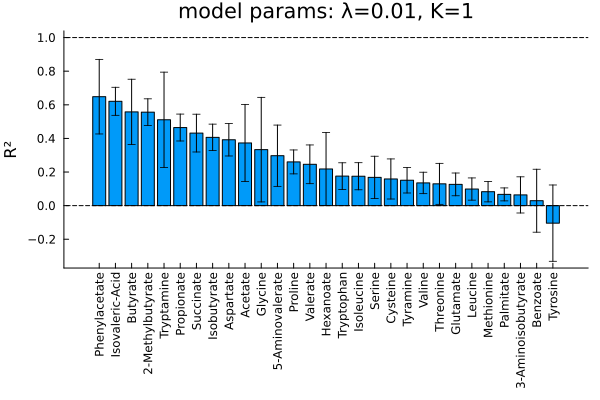

In [971]:
measure_pltdf = groupby(oof_preds_df_stacked, [:metabolite_name, :fold]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df,
        :rsquared => mean,
        :rsquared => std,
    ) |>
    df -> df[keepmetabolites_mask, :] |>
    df -> sort(df, :rsquared_mean, rev=true);

@df measure_pltdf bar(
    :metabolite_name, :rsquared_mean, yerror=:rsquared_std,
    xticks=((1:sum(keepmetabolites_mask)).-.5, :metabolite_name),
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
)
hline!([0, 1], c=:black, label="", linestyle=:dash)

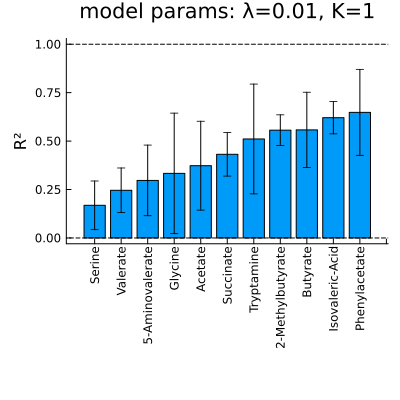

In [972]:
measure_pltdf = groupby(oof_preds_df_stacked, [:metabolite_name, :fold]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> combine(df,
        :rsquared => mean,
        :rsquared => std,
    ) |>
    df -> df[subsetmetabolite_mask, :] |>
    df -> sort(df, :rsquared_mean, rev=false);

@df measure_pltdf bar(
    :metabolite_name, :rsquared_mean, yerror=:rsquared_std,
    xticks=((1:sum(keepmetabolites_mask)).-.5, :metabolite_name),
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(400,400),
)
hline!([0, 1], c=:black, label="", linestyle=:dash)

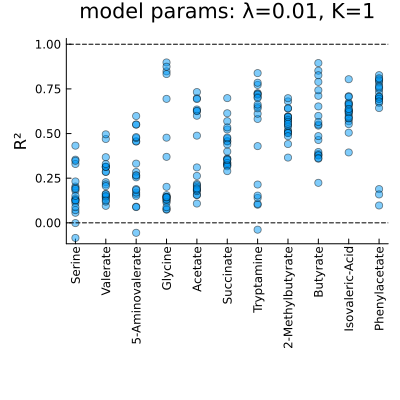

In [973]:
measure_pltdf = groupby(oof_preds_df_stacked, [:metabolite_name, :fold]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> DataFrames.transform(df,
        :rsquared => mean,
    ) |>
    df -> subset(df, :metabolite_name => (x -> x .∈ Ref(subsetmetabolite_names)) ) |>
    df -> sort(df, :rsquared_mean)

@df measure_pltdf dotplot(string.(round.(:rsquared_mean, digits=3)), :rsquared, #yerror=:rsquared_std,
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    alpha=.5,
    mode=:none,
    xticks=((1:length(subsetmetabolite_names)) .- 0.5, unique(:metabolite_name)),
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(400,400),    
)
hline!([0, 1], c=:black, label="", linestyle=:dash)

In [1088]:
filter(:rsquared => !isfinite, measure_pltdf)

Row,metabolite_name,fold,rsquared,rsquared_mean
,String31,Int64,Float64,Float64
1,4-Methylvalerate,9,-Inf,-0.174849
2,4-Methylvalerate,17,-Inf,-0.174849
3,4-Methylvalerate,19,-Inf,-0.174849


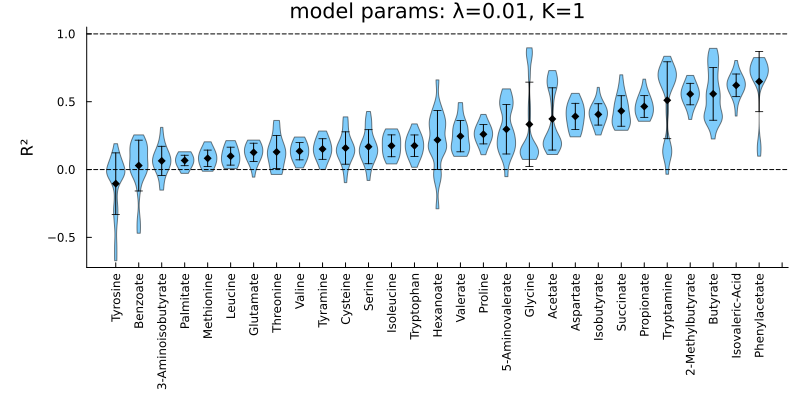

In [1103]:
measure_pltdf = oof_preds_df_stacked |>
    df -> subset(df, :metabolite_name => (x -> x .∈ Ref(orderedmetabolites_names[keepmetabolites_mask])) ) |>
    df -> groupby(df, [:metabolite_name, :fold]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> DataFrames.transform(df,
        # :rsquared => (x->mean(filter(isfinite, x))) => :rsquared_mean,
        :rsquared => mean => :rsquared_mean,
    ) |>
    df -> sort(df, :rsquared_mean)

@df measure_pltdf violin(string.(round.(:rsquared_mean, digits=3)), :rsquared, #yerror=:rsquared_std,
    xrotation=90,
    label="",
    grid=false,
    bottommargin=15Plots.Measures.mm,
    leftmargin=7Plots.Measures.mm,
    alpha=.5,
    mode=:none,
    xticks=((1:length(orderedmetabolites_names)) .- 0.5, unique(:metabolite_name)),
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(800,400),    
)

groupby(measure_pltdf, :metabolite_name) |>
    df->combine(df,
        :rsquared => mean,
        :rsquared => std) |>
    df -> @df df scatter!(
        string.(round.(:rsquared_mean, digits=3)), 
        :rsquared_mean, 
        yerror=:rsquared_std,
        markershape=:diamond,
        c=:black,
        label="",
        )

hline!([0, 1], c=:black, label="", linestyle=:dash)

In [1104]:
savefig(joinpath(pdir, "rsquared_violin_of_allmetabolites_with10pctmeasurments.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model/rsquared_violin_of_allmetabolites_with10pctmeasurments.pdf"

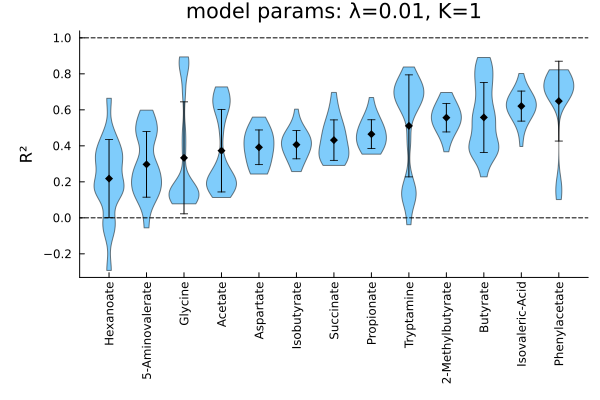

In [1120]:
measure_pltdf = oof_preds_df_stacked |>
    df -> subset(df, :metabolite_name => (x -> x .∈ Ref(orderedmetabolites_names[keepmetabolites_mask])) ) |>
    df -> groupby(df, [:metabolite_name, :fold]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> DataFrames.transform(df,
        # :rsquared => (x->mean(filter(isfinite, x))) => :rsquared_mean,
        :rsquared => mean => :rsquared_mean,
        :rsquared => maximum => :rsquared_max,
    ) |>
    df -> subset(df, 
        :rsquared_max => (x -> x .> .5),
    ) |>
    df -> sort(df, :rsquared_mean)

@df measure_pltdf violin(string.(round.(:rsquared_mean, digits=3)), :rsquared, #yerror=:rsquared_std,
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    leftmargin=5Plots.Measures.mm,
    alpha=.5,
    mode=:none,
    xticks=((1:length(unique(:metabolite_name))) .- 0.5, unique(:metabolite_name)),
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(600,400),    
)

groupby(measure_pltdf, :metabolite_name) |>
    df->combine(df,
        :rsquared => mean,
        :rsquared => std) |>
    df -> @df df scatter!(
        string.(round.(:rsquared_mean, digits=3)), 
        :rsquared_mean, 
        yerror=:rsquared_std,
        markershape=:diamond,
        c=:black,
        label="",
        )

hline!([0, 1], c=:black, label="", linestyle=:dash)

In [1119]:
savefig(joinpath(pdir, "rsquared_violin_of_allmetabolites_with1foldgreaterthan1half.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model/rsquared_violin_of_allmetabolites_with1foldgreaterthan1half.pdf"

In [1123]:
predictable_metabolite_names = unique(measure_pltdf.metabolite_name)

13-element Vector{String31}:
 "Hexanoate"
 "5-Aminovalerate"
 "Glycine"
 "Acetate"
 "Aspartate"
 "Isobutyrate"
 "Succinate"
 "Propionate"
 "Tryptamine"
 "2-Methylbutyrate"
 "Butyrate"
 "Isovaleric-Acid"
 "Phenylacetate"

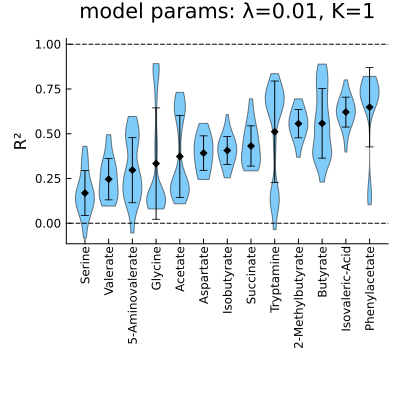

In [ ]:
measure_pltdf = groupby(oof_preds_df_stacked, [:metabolite_name, :fold]) |>
    df -> combine(df, 
        [:preds, :truth] => ((yhat, y) -> rsquared(yhat, y)) => :rsquared,
    ) |>
    df -> groupby(df, :metabolite_name) |>
    df -> DataFrames.transform(df,
        :rsquared => mean,
    ) |>
    df -> subset(df, :metabolite_name => (x -> x .∈ Ref(subsetmetabolite_names)) ) |>
    df -> sort(df, :rsquared_mean)

@df measure_pltdf violin(string.(round.(:rsquared_mean, digits=3)), :rsquared, #yerror=:rsquared_std,
    xrotation=90,
    label="",
    grid=false,
    bottommargin=10Plots.Measures.mm,
    alpha=.5,
    mode=:none,
    xticks=((1:length(subsetmetabolite_names)) .- 0.5, unique(:metabolite_name)),
    title="model params: λ=$λ, K=$K",
    ylabel="R²",
    size=(400,400),    
)

groupby(measure_pltdf, :metabolite_name) |>
    df->combine(df,
        :rsquared => mean,
        :rsquared => std) |>
    df -> @df df scatter!(
        string.(round.(:rsquared_mean, digits=3)), 
        :rsquared_mean, 
        yerror=:rsquared_std,
        markershape=:diamond,
        c=:black,
        label="",
        )

hline!([0, 1], c=:black, label="", linestyle=:dash)

In [ ]:
savefig(joinpath())

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model"

In [1000]:
coef_avgperfold = coefdf |>
    df -> groupby(df, [:metabolite_name, :node_id]) |>
    df -> combine(df, 
        :coef => (x-> mean(x) - 1std(x)) => :coef_lowerbound,
        :coef => (x-> mean(x) + 1std(x)) => :coef_upperbound,
        :coef => (x-> mean(x)) => :coef_mean,
        :coef => (x-> mean(abs.(x))) => :coef_meanabs,
        :treedist => mean,
    ) |>
    df -> DataFrames.transform(df,
        [:coef_lowerbound, :coef_upperbound] => ((lo, hi) -> lo .> 0 .|| hi .< 0) => :isnonzero,
    );

In [976]:
any(coef_avgperfold.isnonzero)

false

In [977]:
coef_mtxdf = unstack(coef_avgperfold, :metabolite_name, :node_id, :isnonzero) |>
    df -> df[indexin(orderedmetabolites_names, df.metabolite_name), :] |>
    df -> df[keepmetabolites_mask, :] |>
    df -> sort(df, names(df)[2:end]);

In [1005]:
coef_mtxdf = unstack(coef_avgperfold, :metabolite_name, :node_id, :coef_meanabs) |>
    df -> df[indexin(orderedmetabolites_names, df.metabolite_name), :] |>
    df -> df[keepmetabolites_mask, :] |>
    df -> sort(df, reverse(names(df)[2:end]));

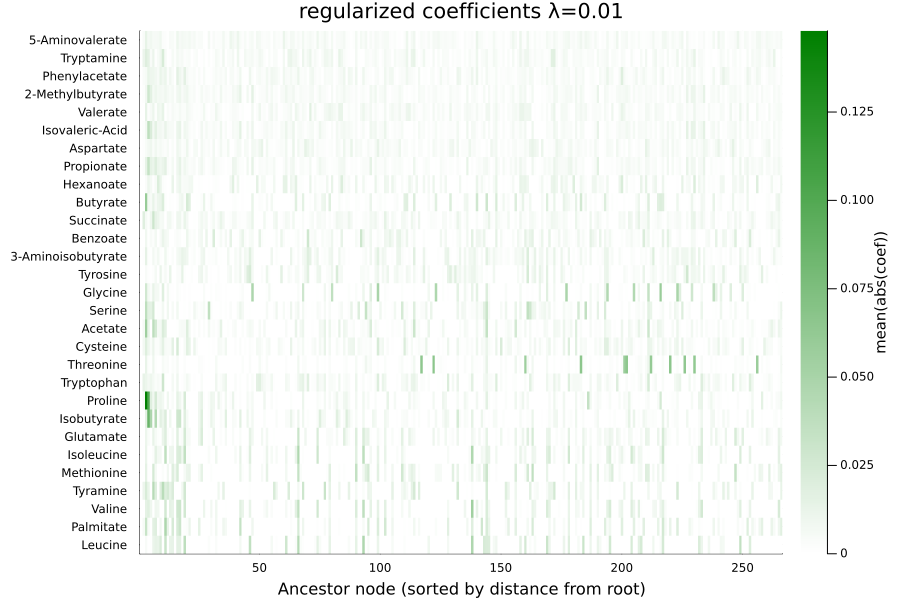

In [1009]:
coefmtx = Matrix(coef_mtxdf[:, 2:end])
roworder = sortperm(vec(sum(abs.(coefmtx), dims=2)), rev=false)

# pltmtx = abs.(coefmtx)
# mnames = coef_mtxdf.metabolite_name
pltmtx = abs.(coefmtx[roworder, :])
mnames = coef_mtxdf.metabolite_name[roworder]
pltmtx = pltmtx ./ sum(pltmtx, dims=2)
heatmap(pltmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), mnames),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="mean(abs(coef))",
    xlabel="Ancestor node (sorted by distance from root)",
    c=[:white, :green],
    size=(900, 600),
)

In [1045]:
subsetmetabolite_names = [
    "Acetate", "Butyrate", "Succinate", "Glycine",
     "Serine", "Valerate","Tryptamine", "5-Aminovalerate",
    "Phenylacetate", "2-Methylbutyrate", "Isovaleric-Acid", 
    "Isobutyrate", "Propionate",
]
subsetmetabolite_mask = indexin(subsetmetabolite_names, orderedmetabolites_names)

13-element Vector{Union{Nothing, Int64}}:
 15
 14
  3
 11
 16
 17
  9
 30
 10
 12
 13
  6
  1

In [1046]:
coef_avgperfold = coefdf |>
    df -> groupby(df, [:metabolite_name, :node_id]) |>
    df -> combine(df, 
        :coef => (x-> mean(x) - 1std(x)) => :coef_lowerbound,
        :coef => (x-> mean(x) + 1std(x)) => :coef_upperbound,
        :coef => (x-> mean(x)) => :coef_mean,
        :coef => (x-> mean(abs.(x))) => :coef_meanabs,
        :coef => (x-> median(x)) => :coef_median,
        :coef => (x-> quantile(x, 0.25)) => :coef_Q2,
        :coef => (x-> quantile(x, 0.75)) => :coef_Q3,
        :treedist => mean,
        ) |>
    df -> DataFrames.transform(df,
        [:coef_lowerbound, :coef_upperbound] => ((lo, hi) -> lo .> 0 .|| hi .< 0) => :isnonzero,
    );

In [1058]:
coef_mtxdf = unstack(coef_avgperfold, :metabolite_name, :node_id, :coef_meanabs) |>
    df -> df[indexin(orderedmetabolites_names, df.metabolite_name), :] |>
    df -> df[reverse(subsetmetabolite_mask), :]; #|>
    # df -> sort(df, names(df)[2:end]);

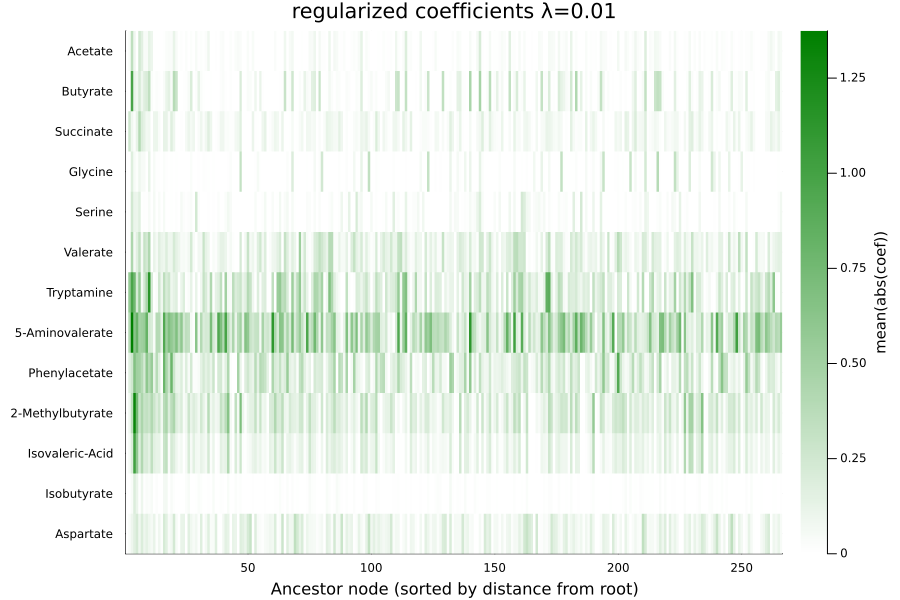

In [1059]:
coefmtx = Matrix(coef_mtxdf[:, 2:end])
roworder = sortperm(vec(sum(abs.(coefmtx), dims=2)), rev=true)
pltmtx = abs.(coefmtx)
# pltmtx = abs.(coefmtx[roworder, :])
# pltmtx = pltmtx ./ sum(pltmtx, dims=2)
heatmap(pltmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), coef_mtxdf.metabolite_name),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="mean(abs(coef))",
    xlabel="Ancestor node (sorted by distance from root)",
    c=[:white, :green],
    size=(900, 600),
)

In [1128]:
coefdf_avgbytreedist = groupby(coefdf, [:metabolite_name, :treedist]) |>
    df -> combine(df, 
        :coef => (x-> mean(x) - 1std(x)) => :coef_lowerbound,
        :coef => (x-> mean(x) + 1std(x)) => :coef_upperbound,
        :coef => (x-> mean(x)) => :coef_mean,
        :coef => (x-> mean(abs.(x))) => :coef_meanabs,
        :coef => (x-> median(x)) => :coef_median,
        :coef => (x-> quantile(x, 0.25)) => :coef_Q2,
        :coef => (x-> quantile(x, 0.75)) => :coef_Q3,
        nrow
    ) |>
    df -> DataFrames.transform(df,
        [:coef_lowerbound, :coef_upperbound] => ((lo, hi) -> lo .> 0 .|| hi .< 0) => :isnonzero,
    );

In [1129]:
predictable_metabolite_idx = indexin(predictable_metabolite_names, orderedmetabolites_names);

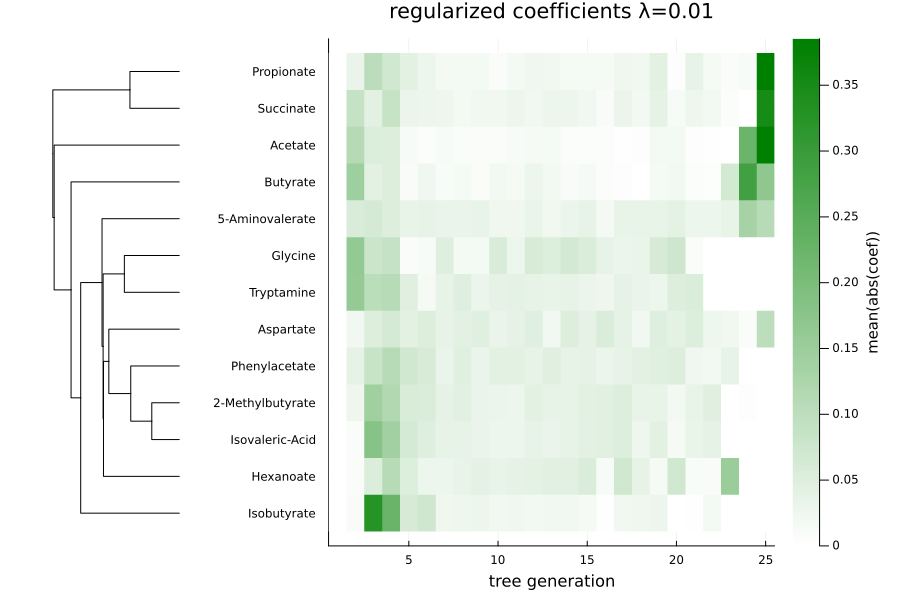

In [1137]:
coef_mtxdf = unstack(coefdf_avgbytreedist, :metabolite_name, :treedist, :coef_meanabs) |>
    df -> df[indexin(orderedmetabolites_names, df.metabolite_name), :] |>
    df -> df[reverse(predictable_metabolite_idx), :] #|> 
coefmtx = Matrix(coef_mtxdf[:, 2:end])
coefmtx = coefmtx ./ sum(coefmtx, dims=2)
pltmtx = coefmtx

rowhc = hclust(pairwise(Euclidean(), coefmtx, dims=1), branchorder=:optimal);
roworder = rowhc.order #sortperm(vec(sum(abs.(coefmtx), dims=2)), rev=true)
# pltmtx = abs.(coefmtx)
# rownames = coef_mtxdf.metabolite_name
pltmtx = abs.(pltmtx[roworder, :])
rownames = coef_mtxdf.metabolite_name[roworder]

tplot = plot(
    # readnw(SPI.nwstr(rowhc, String.(coef_mtxdf.metabolite_name), labelinternalnodes=false)), 
    readnw(SPI.nwstr(rowhc, repeat([""], length(rowhc.order)), labelinternalnodes=false)), 
    fs=1
)

hplot = heatmap(pltmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), rownames),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="mean(abs(coef))",
    xlabel="tree generation",
    c=[:white, :green],
    size=(900, 600),
    margin=3Plots.Measures.mm,
)

layout = @layout [a{.2w} b]
plot(tplot, hplot, link=:y, layout=layout)

In [1139]:
savefig(joinpath(pdir, "Coeff_heatmap_clusteredpredictablemetabolites.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model/Coeff_heatmap_clusteredpredictablemetabolites.pdf"

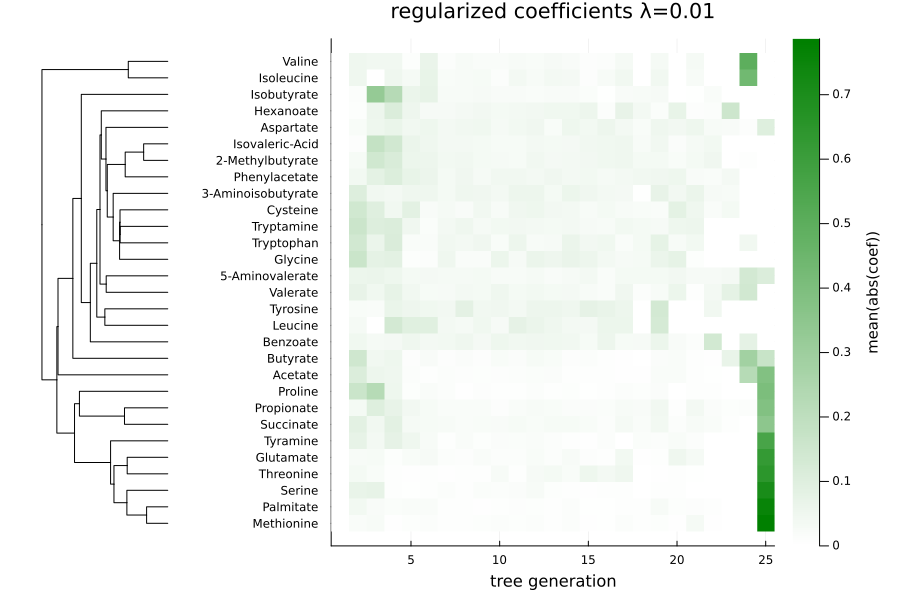

In [1164]:
coef_mtxdf = unstack(coefdf_avgbytreedist, :metabolite_name, :treedist, :coef_meanabs) |>
    df -> df[indexin(orderedmetabolites_names, df.metabolite_name), :] |>
    df -> df[keepmetabolites_mask, :] #|> 
coefmtx = Matrix(coef_mtxdf[:, 2:end])
coefmtx = coefmtx ./ sum(coefmtx, dims=2)
pltmtx = coefmtx

rowhc = hclust(pairwise(Euclidean(), coefmtx, dims=1), branchorder=:optimal);
roworder = rowhc.order #sortperm(vec(sum(abs.(coefmtx), dims=2)), rev=true)
# pltmtx = abs.(coefmtx)
# rownames = coef_mtxdf.metabolite_name
pltmtx = abs.(pltmtx[roworder, :])
rownames = coef_mtxdf.metabolite_name[roworder]

tplot = plot(
    # readnw(SPI.nwstr(rowhc, String.(coef_mtxdf.metabolite_name), labelinternalnodes=false)), 
    readnw(SPI.nwstr(rowhc, repeat([""], length(rowhc.order)), labelinternalnodes=false)), 
    fs=1
)

hplot = heatmap(pltmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), rownames),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="mean(abs(coef))",
    xlabel="tree generation",
    c=[:white, :green],
    size=(900, 600),
    margin=3Plots.Measures.mm,
)

layout = @layout [a{.2w} b]
plot(tplot, hplot, link=:y, layout=layout)

In [1165]:
savefig(joinpath(pdir, "Coeff_heatmap_clusteredmetabolites_greaterthan10pctmeasurements.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/metabolite_SBA_Lasso_model/Coeff_heatmap_clusteredmetabolites_greaterthan10pctmeasurements.pdf"

In [1148]:
metabolite_name = "Acetate"

"Acetate"

In [1190]:
# predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
#     df -> groupby(df, :row_id) |>
#     df -> combine(df, 
#         :metabolite_name => first => :metabolite_name,
#         :truth => first => :truth,
#         :preds => mean,
#         :preds => std,
#     )

In [1205]:
for r in 1:5
    predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
        df -> DataFrames.transform(df, :fold => (x->((x.-1) .÷ 4).+1) => :resample) |>
        df -> subset(df, :resample => x-> x.==r) |>
        df -> sort(df, :row_id)

    lims = extrema(vcat(predsdf.preds, predsdf.truth))
    lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
    plot(identity, -20, 20, c=:black, lw=.5, label="")
    p1 = @df predsdf scatter!(:preds, :truth,
        group=trnYdf.species,
        lims=lims,
        title="SPI LASSO (λ=.01, K=1, resmp=$r)",
        ylabel=metabolite_name * " (truth)",
        xlabel=metabolite_name * " (prediction)",
        grid=false,
        markerstrokewidth=0,
        ratio=1,
        c=speciescolors_ordered,
        size=(900,600),
        legend=:outerright,
        xrotation=90,
        alpha=.5,
        margin=5Plots.Measures.mm,

    )
    savefig(joinpath(pdir, "$(metabolite_name)_resample$(r)_scatter_preds_vs_truth.pdf"))
end

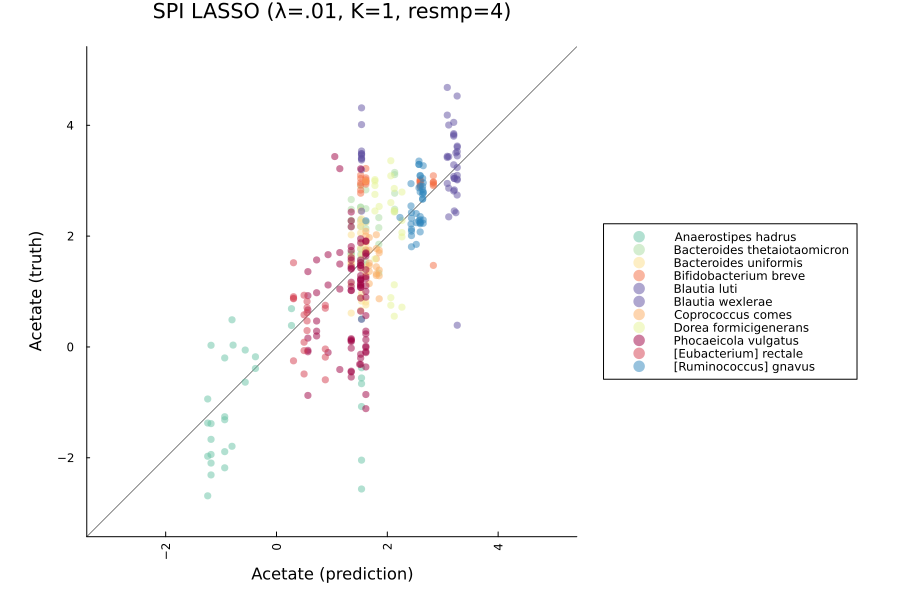

In [1204]:
predsdf = filter(:metabolite_name => ==(metabolite_name), oof_preds_df_stacked) |>
    df -> DataFrames.transform(df, :fold => (x->((x.-1) .÷ 4).+1) => :resample) |>
    df -> subset(df, :resample => x-> x.==4) |>
    df -> sort(df, :row_id)

lims = extrema(vcat(predsdf.preds, predsdf.truth))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot(identity, -20, 20, c=:black, lw=.5, label="")
    p1 = @df predsdf scatter!(:preds, :truth,
    group=trnYdf.species,
    lims=lims,
    title="SPI LASSO (λ=.01, K=1, resmp=4)",
    ylabel=metabolite_name * " (truth)",
    xlabel=metabolite_name * " (prediction)",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
    margin=5Plots.Measures.mm,
)

## Show SPI-LASSO prediction results with Ancestral Encoding

In [ ]:
oof_preds_df = CSV.read(joinpath(rdir, "oof_predictions_SPItreeLASSO_ancestralencoding_lambda=$(λ)_support=$(support)_ncuts=$(NCUTS).csv"), DataFrame)
inf_preds_df = CSV.read(joinpath(rdir, "infold_predictions_SPItreeLASSO_ancestralencoding_lambda=$(λ)_support=$(support)_ncuts=$(NCUTS).csv"), DataFrame)
coefdf = CSV.read(joinpath(rdir, "coefs_SPItreeLASSO_ancestralencoding_lambda=$(λ)_support=$(support)_ncuts=$(NCUTS).csv"), DataFrame);

In [ ]:
knn_oof_preds_df = CSV.read(projectdir("_research", "metabolite_knn_model", "oof_preds__K=1_nboot=100_support=90.csv"), DataFrame);
lasso_oof_preds_df = CSV.read(projectdir("_research", "metabolite_lasso_model", "oof_lasso_preds_lambda=0.01.csv"), DataFrame);

In [ ]:
# oof_preds_df = CSV.read(joinpath(rdir, "oof_predictions_SPItreeLASSO_lambda=0.01_support=0_ncuts=10.csv"), DataFrame)
# coefdf = CSV.read(joinpath(rdir, "coefs_SPItreeLASSO_lambda=0.01_support=0_ncuts=10.csv"), DataFrame);

In [ ]:
# metabolite_name = "Propionate"
# metabolite_name = "Acetate"
# metabolite_name = "Aspartate"
# metabolite_name = "Succinate"
# metabolite_name = "Glycine"
metabolite_name = "Serine"

# metabolite_name = "Butyrate"
# metabolite_name = "Tryptamine"
# metabolite_name = "Phenylacetate"


# metabolite_name = "Lysine"
# metabolite_name = "Desaminotyrosine"
# metabolite_name = "Phenol"

In [ ]:
preds_knn = knn_oof_preds_df[:, metabolite_name * "_pred_mean"];

In [ ]:
predslasso = oof_preds_df[:,  metabolite_name * "_pred_sbalasso"]
truth = oof_preds_df[:, metabolite_name * "_true"]
species = trnYdf.species[Int.(oof_preds_df.row_id)];

lims = extrema(vcat(predslasso, truth))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(predslasso, truth,
    group=species,
    lims=lims,
    title="SPI LASSO prediction K=$(K) support>$support",
    ylabel=metabolite_name * " (truth)",
    xlabel=metabolite_name * " (prediction)",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
    margin=5Plots.Measures.mm,
)

In [ ]:
savefig(joinpath(pdir, "$(metabolite_name)_scatter_predictions_SBAlasso_model_K=$(K)_support=$(support).pdf"))

In [ ]:
lims = extrema(vcat(predslasso, truth))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(preds_knn, truth,
    group=species,
    lims=lims,
    title="SPI KNN prediction K=1 support>90",
    ylabel=metabolite_name * " (truth)",
    xlabel=metabolite_name * " (prediction)",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
    margin=5Plots.Measures.mm,

)

In [ ]:
# savefig(joinpath(pdir, "$(metabolite_name)_scatter_predictions_knn_model_K=$(K)_support=$(support).pdf"))

In [ ]:
lims = extrema(vcat(predslasso, truth))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(predslasso, preds_knn,
    group=species,
    lims=lims,
    title="SBA LASSO vs. SBA KNN predictions",
    ylabel=metabolite_name * " SBA knn (prediction)",
    xlabel=metabolite_name * " SBA lasso (prediction)",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
    margin=5Plots.Measures.mm,
)

In [ ]:
# savefig(joinpath(pdir, "$(metabolite_name)_scatter_prediction_comparison_knn_to_SBAlasso_K=$(K)_support=$(support).pdf"))

### Coefs plot

In [ ]:
coef_mtxdf = coefdf |>
    df -> DataFrames.groupby(df, [:metabolite_name, :treedepth]) |>
    df -> DataFrames.combine(df, :ceof => (x->abs.(mean(x))) => :coef) |>
    df -> unstack(df, :metabolite_name, :treedepth, :coef) |>
    df -> df[keepmetabolites_mask, :] |>
    df -> sort(df, names(df)[2:end]);

In [ ]:
coefmtx = Matrix(coef_mtxdf[:, 2:end])
heatmap(coefmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), coef_mtxdf.metabolite_name),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="abs(mean(coef))",
    xlabel="tree cut",
    c=[:white, :green],
    # c=:viridis,
    size=(900, 600),
)

In [ ]:
coef_mtxdf = coefdf |>
    df -> DataFrames.groupby(df, [:metabolite_name, :treedepth]) |>
    df -> DataFrames.combine(df, :ceof => (x->maximum(abs.(x))) => :coef) |>
    df -> unstack(df, :metabolite_name, :treedepth, :coef) |>
    df -> df[keepmetabolites_mask, :] |>
    df -> sort(df, names(df)[2:end]);

In [ ]:
coefmtx = Matrix(coef_mtxdf[:, 2:end])
heatmap(coefmtx,
    title="regularized coefficients λ=$λ",
    yticks=(1:size(coefmtx, 1), coef_mtxdf.metabolite_name),
    # xticks=(2:2:10, (2:2:10) .* 10),
    # clims = extrema(coefmtx) |> x->abs.(x) |> maximum |> x->(-x, x),
    colorbartitle="max(abs(coef))",
    xlabel="tree cut",
    c=[:white, :green],
    size=(900, 600),
)

In [ ]:
coef_mtxdf = coefdf |>
    df -> DataFrames.groupby(df, [:metabolite_name]) |>
    df -> DataFrames.combine(df, :ceof => (x->sum(x.>0.05) / length(x)) => :coef) |>
    # df -> unstack(df, :metabolite_name, :treedepth, :coef) |>
    df -> sort(df, :coef)

### Performance plots

In [ ]:
mnames = string.(orderedmetabolites_names[keepmetabolites_mask]);

In [ ]:
function get_scores(fun, df, predname; groupcol=:fold, mnames=mnames) 
    combine(groupby(df, groupcol)) do gdf 
        ŷs = gdf[:, Cols(mnames .* "_pred_".* predname)]
        ys = gdf[:, Cols(mnames .* "_true")]
        scores = map(zip(eachcol(ŷs), eachcol(ys))) do (ŷ, y)
            fun(ŷ, y)
        end |> permutedims
        scores
    end |>
    Matrix |>
    x->getindex(x, :, axes(x,2)[2:end]) |>
    permutedims
end

In [ ]:
func = rsquared

sbalasso_scores = map(["sbalasso"]) do type
    scores = get_scores(func, oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
knn_scores = map(["mean"]) do type
    scores = get_scores(func, knn_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
all_scores = map(["full", "top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2), std(scores, dims=2)
end

scores_means = hcat(first.(sbalasso_scores)..., first.(knn_scores)..., first.(all_scores)...)
scores_stds = hcat(last.(sbalasso_scores)..., last.(knn_scores)..., last.(all_scores)...);

In [ ]:
groupedbar(scores_means,
    errorbar=scores_stds,
    xticks=(1:length(mnames), mnames),
    xtickfontsize=9,
    xrotation=90,
    ylabel="R²",
    # label=["SPI-NN" "full lasso" "top10 lasso" "top3 lasso"],
    label=["SBA-lasso" "SBA-knn" "full lasso" "top3 lasso"],
    xgrid=false,
    size=(900, 400),
    leftmargin=.5Plots.Measures.cm,
    bottommargin=2Plots.Measures.cm,
    legend=:outertop,
)
vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "rsquared_groupedbar_SBAlasso-SBAknn-fulllasso-top3lasso.pdf"))

In [ ]:
func = mae

sbalasso_scores = map(["sbalasso"]) do type
    scores = get_scores(func, oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
knn_scores = map(["mean"]) do type
    scores = get_scores(func, knn_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
all_scores = map(["full", "top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2), std(scores, dims=2)
end

scores_means = hcat(first.(sbalasso_scores)..., first.(knn_scores)..., first.(all_scores)...)
scores_stds = hcat(last.(sbalasso_scores)..., last.(knn_scores)..., last.(all_scores)...);

In [ ]:
groupedbar(scores_means,
    errorbar=scores_stds,
    xticks=(1:length(mnames), mnames),
    xtickfontsize=9,
    xrotation=90,
    ylabel="MAE (log2FC from standard)",
    # label=["SPI-NN" "full lasso" "top10 lasso" "top3 lasso"],
    label=["SBA-lasso" "SBA-knn" "full lasso" "top3 lasso"],
    xgrid=false,
    size=(900, 400),
    leftmargin=.5Plots.Measures.cm,
    bottommargin=2Plots.Measures.cm,
    legend=:outertop,
)
vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "mae_groupedbar_SBAlasso-SBAknn-fulllasso-top3lasso.pdf"))

In [ ]:
mnames = [
    "Succinate", 
    "Tryptamine",
    "Phenylacetate",
    "Glycine",
    "Butyrate",
    "Acetate",
    "Serine",
    "Valerate",
    "5-Aminovalerate",
    "2-Methylbutyrate",
    "Isovaleric-Acid"
]

In [ ]:
function get_scores(fun, df, predname; groupcol=:fold, mnames=mnames) 
    combine(groupby(df, groupcol)) do gdf 
        ŷs = gdf[:, Cols(mnames .* "_pred_".* predname)]
        ys = gdf[:, Cols(mnames .* "_true")]
        scores = map(zip(eachcol(ŷs), eachcol(ys))) do (ŷ, y)
            fun(ŷ, y)
        end |> permutedims
        scores
    end |>
    Matrix |>
    x->getindex(x, :, axes(x,2)[2:end]) |>
    permutedims
end

In [ ]:
func = rsquared

sbalasso_scores = map(["sbalasso"]) do type
    scores = get_scores(func, oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
knn_scores = map(["mean"]) do type
    scores = get_scores(func, knn_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
all_scores = map(["top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2), std(scores, dims=2)
end

scores_means = hcat(first.(sbalasso_scores)..., first.(knn_scores)..., first.(all_scores)...)
scores_stds = hcat(last.(sbalasso_scores)..., last.(knn_scores)..., last.(all_scores)...);

In [ ]:
groupedbar(scores_means,
    errorbar=scores_stds,
    xticks=(1:length(mnames), mnames),
    xtickfontsize=9,
    xrotation=90,
    ylabel="R²",
    # label=["SPI-NN" "full lasso" "top10 lasso" "top3 lasso"],
    label=["SBA-lasso" "SBA-knn" "full lasso" "top3 lasso"],
    xgrid=false,
    size=(900, 400),
    leftmargin=.5Plots.Measures.cm,
    bottommargin=2Plots.Measures.cm,
    legend=:outertop,
    c=[5 1 4],
)
# vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "rsquared_groupedbar_SBAlasso-SBAknn-fulllasso-top3lasso.pdf"))

In [ ]:
func = mae

sbalasso_scores = map(["sbalasso"]) do type
    scores = get_scores(func, oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
knn_scores = map(["mean"]) do type
    scores = get_scores(func, knn_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2)|>vec, std(scores, dims=2)|>vec
end
all_scores = map(["top3"]) do type
    scores = get_scores(func, lasso_oof_preds_df, type; groupcol="fold", mnames)
    mean(scores, dims=2), std(scores, dims=2)
end

scores_means = hcat(first.(sbalasso_scores)..., first.(knn_scores)..., first.(all_scores)...)
scores_stds = hcat(last.(sbalasso_scores)..., last.(knn_scores)..., last.(all_scores)...);

In [ ]:
groupedbar(scores_means,
    errorbar=scores_stds,
    xticks=(1:length(mnames), mnames),
    xtickfontsize=9,
    xrotation=90,
    ylabel="MAE (log2FC from standard)",
    # label=["SPI-NN" "full lasso" "top10 lasso" "top3 lasso"],
    label=["SBA-lasso" "SBA-knn" "full lasso" "top3 lasso"],
    xgrid=false,
    size=(900, 400),
    leftmargin=.5Plots.Measures.cm,
    bottommargin=2Plots.Measures.cm,
    legend=:outertop,
    c=[5 1 4],
)
# vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "mae_groupedbar_SBAlasso-SBAknn-fulllasso-top3lasso.pdf"))

In [ ]:
oof_preds_df_stacked

In [ ]:
lasso_oof_preds_df = CSV.read(projectdir("_research/metabolite_lasso_model/oof_lasso_preds_lambda=0.01.csv"), DataFrame);

In [ ]:
mergeddf = leftjoin(oof_preds_df, lasso_oof_preds_df, on=:row_id, makeunique=true);

In [ ]:
preds_knn = mergeddf[:, metabolite_name * "_pred_mean"]
preds_full = mergeddf[:, metabolite_name * "_pred_full"]
preds_top10 = mergeddf[:, metabolite_name * "_pred_top10"]
preds_top3 = mergeddf[:, metabolite_name * "_pred_top3"]
preds_std = mergeddf[:, metabolite_name * "_pred_std"]
truth = mergeddf[:, metabolite_name * "_true"]
species = trnYdf.species[Int.(mergeddf.row_id)];

In [ ]:
lims = extrema(vcat(preds_knn, preds_full))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(preds_knn, preds_full,
    group=species,
    lims=lims,
    title="$metabolite_name comparison",
    ylabel="Full spectrum prediction",
    xlabel="KNN prediction K=$K support>$(support)",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
)

In [ ]:
savefig(joinpath(pdir, "$(metabolite_name)_comparison_knn_to_full_K=$(K)_support=$(support).pdf"))

In [ ]:
preds_full = mergeddf[:, metabolite_name * "_pred_full"]
# preds_std = mergeddf[:, metabolite_name * "_pred_std"]
truth = mergeddf[:, metabolite_name * "_true"]
species = trnYdf.species[Int.(mergeddf.row_id)];

lims = extrema(vcat(preds_full, truth))
lims =  lims .+ (-(lims[2] - lims[1]) * 0.1, (lims[2] - lims[1]) * 0.1)
plot((x)->x, [-20, 20], c=:black, lw=.5, label="")
p1 = scatter!(preds_full, truth,
    group=species,
    lims=lims,
    title="lasso full spectrum prediction",
    ylabel=metabolite_name,
    xlabel="prediction",
    grid=false,
    markerstrokewidth=0,
    ratio=1,
    c=speciescolors_ordered,
    size=(900,600),
    legend=:outerright,
    xrotation=90,
    alpha=.5,
    # legendfontsize=6,
)

### R squared

In [ ]:
rsquaredoflassovsspinn = map(orderedmetabolites_names[keepmetabolites_mask]) do mname
    rsquared(
        mergeddf[:, mname * "_pred_full"], 
        mergeddf[:, mname * "_pred_mean"], 
    )
end

In [ ]:
bar(rsquaredoflassovsspinn,
    # errorbar=corrbias_stds,
    ylims=(-0.6, 1.1),
    yticks=-.5:.25:1,
    xticks=(1:length(rsquaredoflassovsspinn), orderedmetabolites_names[keepmetabolites_mask]),
    xtickfontsize=9,
    xrotation=-90,
    title="R² of full spectrum lasso vs. SPI nearest neighbors (k = $K, support ≥ $support)",
    label="R²",
    xgrid=false,
    size=(1500, 400),
    bottommargin=25Plots.Measures.mm,
    legend=:none,
)
vline!([8.5, 8+19+.5], c=:grey, label="")

In [ ]:
savefig(joinpath(pdir, "Rsquared_of_fulllasso_vs_SPI-NN_K=$(K)_support=$(support).pdf"))